
# Credit Risk Default Prediction

**Dataset:** `df_Default.csv`  
**Target:** `Status` (1 = default, 0 = non-default)


In [4]:
# Core imports 
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Modeling utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier          #  for sanity test
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, recall_score
)
from sklearn.utils import shuffle                        #  sanity test

# Optional model — XGBoost
import warnings
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    warnings.warn("xgboost not available; Logistic Regression baseline will run.")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Data Load 

In [5]:

DATA_PATH = Path("C:/Users/murie/OneDrive/Desktop/PROJECTS/creditscore/Loan_Default_Data.csv")
TARGET = "Status" #column we want to predict
ID_COL = "ID" #identifier column , not used for training , but splitting


df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH.resolve())
print("Shape:", df.shape)
print("Columns:", list(df.columns))


Loaded: C:\Users\murie\OneDrive\Desktop\PROJECTS\creditscore\Loan_Default_Data.csv
Shape: (148670, 19)
Columns: ['ID', 'year', 'Gender', 'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'lump_sum_payment', 'property_value', 'income', 'credit_type', 'Credit_Score', 'age', 'LTV', 'Region', 'Status', 'dtir1']


### Target distribution and missing values

ID                          int64
year                        int64
Gender                     object
business_or_commercial     object
loan_amount                 int64
rate_of_interest          float64
Interest_rate_spread      float64
Upfront_charges           float64
term                      float64
lump_sum_payment           object
property_value            float64
income                    float64
credit_type                object
Credit_Score                int64
age                        object
LTV                       float64
Region                     object
Status                      int64
dtir1                     float64
dtype: object


Missing per column (top 20):


dtir1                     24121
age                         200
property_value                0
Status                        0
Region                        0
LTV                           0
Credit_Score                  0
credit_type                   0
income                        0
ID                            0
year                          0
term                          0
Upfront_charges               0
Interest_rate_spread          0
rate_of_interest              0
loan_amount                   0
business_or_commercial        0
Gender                        0
lump_sum_payment              0
dtype: int64


Target counts: {0: 112031, 1: 36639}  Proportions: {0: 0.754, 1: 0.246}


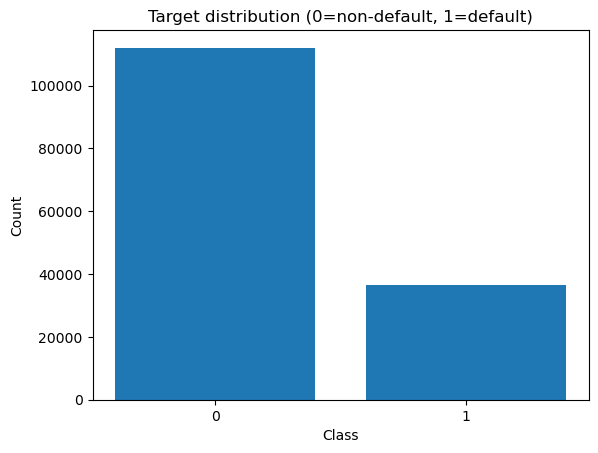

In [6]:
#display data types
display(df.dtypes)
#show missing values
print("\nMissing per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

#checking / plot  of target distribution
counts = df[TARGET].value_counts().sort_index()
print("\nTarget counts:", counts.to_dict(), " Proportions:", (counts/len(df)).round(3).to_dict())

fig = plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target distribution (0=non-default, 1=default)")
plt.xlabel("Class"); plt.ylabel("Count"); plt.show()



## Leakage column drop
- **Identifier-like**: columns whose per-unique target mean is always 0 or 1.
- **Pricing-derived**: `Interest_rate_spread`, `rate_of_interest`, `Upfront_charges` (post-underwriting → leak risk).


In [7]:

def find_identifier_like_columns(df, target):
    bad = []
    for col in df.columns:
        if col == target:
            continue
        try:
            means = df.groupby(col, dropna=True)[target].mean().unique()
            rounded = set(np.round(means, 8))
            if rounded.issubset({0.0, 1.0}):
                bad.append(col)
        except Exception:
            pass
    return bad

leaky_id_cols = find_identifier_like_columns(df, TARGET)
print("Identifier-like columns to drop:", leaky_id_cols)

PRICING_DROP = ["Interest_rate_spread", "rate_of_interest", "Upfront_charges"]
present_pricing = [c for c in PRICING_DROP if c in df.columns]
print("Pricing-derived columns present:", present_pricing)

drop_now = sorted(set(leaky_id_cols + present_pricing))
if drop_now:
    df = df.drop(columns=drop_now)
    print("Dropped columns:", drop_now)
else:
    print("No identifier-like or pricing columns dropped at this step.")


Identifier-like columns to drop: ['ID', 'Interest_rate_spread']
Pricing-derived columns present: ['Interest_rate_spread', 'rate_of_interest', 'Upfront_charges']
Dropped columns: ['ID', 'Interest_rate_spread', 'Upfront_charges', 'rate_of_interest']


##  Deduplicate

In [8]:

before = len(df)
# Conservative dedup (all columns except target)
dedup_subset = [c for c in df.columns if c != TARGET]
df = df.drop_duplicates(subset=dedup_subset)
print(f"Deduplicated: {before - len(df)} rows. New shape: {df.shape}")


Deduplicated: 3 rows. New shape: (148667, 15)



## Train/Val/Test split (Group-aware by ID if available)
- 70/15/15 with **GroupShuffleSplit** if `ID` exists; otherwise stratified.
- ID is removed from features **after** splitting.


In [9]:

X_all = df.drop(columns=[TARGET])
y_all = df[TARGET].astype(int)

has_id = ID_COL in X_all.columns

if has_id:
    groups_all = X_all[ID_COL]
    gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups_all))
    X_temp, X_test = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_temp, y_test = y_all.iloc[tr_idx], y_all.iloc[te_idx]

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1765, random_state=42)
    tr2_idx, va_idx = next(gss2.split(X_temp, y_temp, groups=X_temp[ID_COL]))
    X_train, X_val = X_temp.iloc[tr2_idx], X_temp.iloc[va_idx]
    y_train, y_val = y_temp.iloc[tr2_idx], y_temp.iloc[va_idx]

    groups_train = X_train[ID_COL]
    # Drop ID after split
    for frame in (X_train, X_val, X_test):
        frame.drop(columns=[ID_COL], inplace=True)
    print("Group-aware split used (ID present).")
else:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=0.15, stratify=y_all, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
    )
    groups_train = None
    print("Stratified split used (ID missing).")

print("Shapes: Train", X_train.shape, "Val", X_val.shape, "Test", X_test.shape)


Stratified split used (ID missing).
Shapes: Train (104062, 14) Val (22304, 14) Test (22301, 14)


## Preprocessing pipelines

In [10]:

num_cols_final = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_final = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Final numeric: {len(num_cols_final)}, categorical: {len(cat_cols_final)}")

numeric_tf = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_tf, num_cols_final),
    ('cat', categorical_tf, cat_cols_final)
])

log_reg = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=400, class_weight='balanced', random_state=42))
])

pos = (y_train==1).sum(); neg = (y_train==0).sum()
scale_pos_weight = (neg/pos) if pos>0 else 1.0
print(f"scale_pos_weight for XGB: {scale_pos_weight:.3f}")

xgb = None
if HAS_XGB:
    xgb = Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            eval_metric='logloss', random_state=42, n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        ))
    ])


Final numeric: 8, categorical: 6
scale_pos_weight for XGB: 3.058


## Cross-validation on TRAIN 

In [11]:

def cv_scores_with_groups(model, X, y, groups):
    if groups is not None:
        cv = GroupKFold(n_splits=5)
        aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, groups=groups)
        recs = cross_val_score(model, X, y, scoring='recall',   cv=cv, groups=groups)
    else:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
        recs = cross_val_score(model, X, y, scoring='recall',   cv=cv)
    return aucs, recs

for name, model in [('LogReg', log_reg)] + ([('XGB', xgb)] if xgb is not None else []):
    aucs, recs = cv_scores_with_groups(model, X_train, y_train, groups_train)
    print(f"{name}: ROC-AUC {aucs.mean():.3f} ± {aucs.std():.3f} | Recall(1) {recs.mean():.3f} ± {recs.std():.3f}")


LogReg: ROC-AUC 0.584 ± 0.006 | Recall(1) 0.674 ± 0.031
XGB: ROC-AUC 0.863 ± 0.002 | Recall(1) 0.670 ± 0.003


## Fit best model & tune threshold on Validation (maximize F1)

Selected: XGB
Best threshold (val, max F1): 0.643


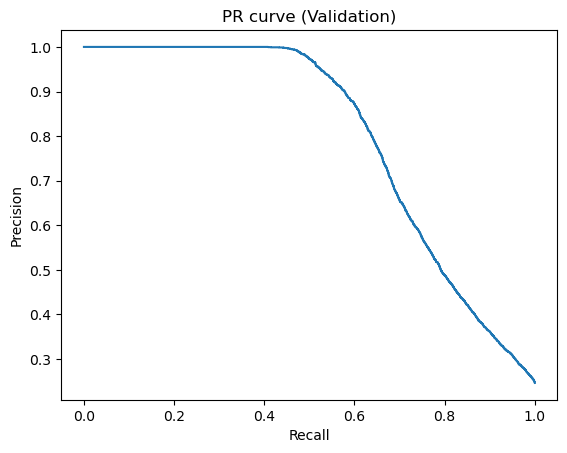

In [12]:

best_model = xgb if xgb is not None else log_reg
print("Selected:", "XGB" if xgb is not None else "LogReg")

best_model.fit(X_train, y_train)
val_proba = best_model.predict_proba(X_val)[:,1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = (2*prec*rec)/(prec+rec + 1e-12)
idx = int(np.nanargmax(f1))
best_threshold = thr[idx-1] if idx>0 else 0.5
print(f"Best threshold (val, max F1): {best_threshold:.3f}")

fig = plt.figure(); plt.plot(rec, prec)
plt.title("PR curve (Validation)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()


## Final evaluation on Test

=== Classification report (Test) ===
              precision    recall  f1-score   support

           0      0.888     0.968     0.926     16805
           1      0.863     0.626     0.726      5496

    accuracy                          0.883     22301
   macro avg      0.875     0.797     0.826     22301
weighted avg      0.882     0.883     0.877     22301

Confusion matrix:
 [[16259   546]
 [ 2055  3441]]
ROC-AUC (Test): 0.870
PR-AUC  (Test): 0.813


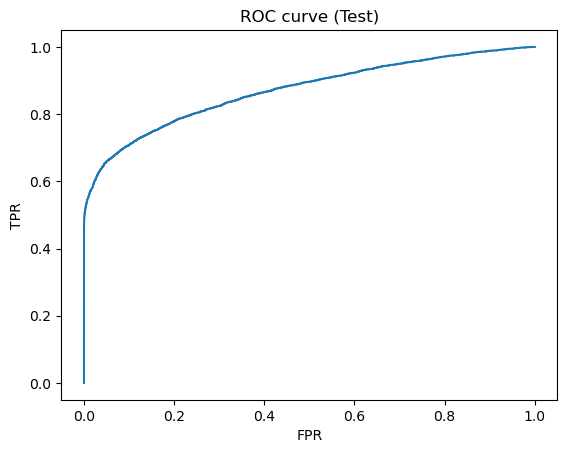

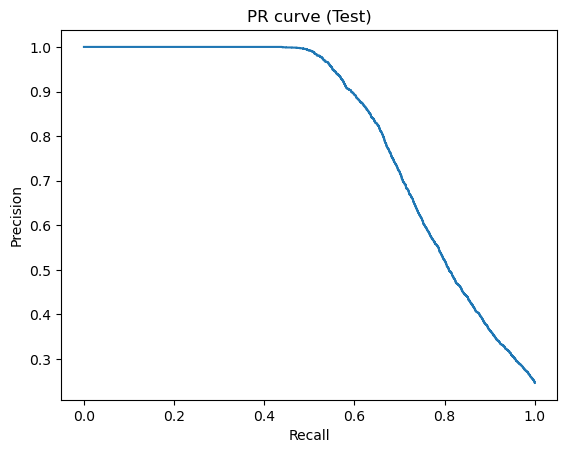

In [13]:

test_proba = best_model.predict_proba(X_test)[:,1]
test_pred = (test_proba >= best_threshold).astype(int)

print("=== Classification report (Test) ===")
print(classification_report(y_test, test_pred, digits=3))
cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

print(f"ROC-AUC (Test): {roc_auc_score(y_test, test_proba):.3f}")
print(f"PR-AUC  (Test): {average_precision_score(y_test, test_proba):.3f}")

fpr, tpr, _ = roc_curve(y_test, test_proba)
fig = plt.figure(); plt.plot(fpr, tpr)
plt.title("ROC curve (Test)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

prec_t, rec_t, _ = precision_recall_curve(y_test, test_proba)
fig = plt.figure(); plt.plot(rec_t, prec_t)
plt.title("PR curve (Test)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()


## Sanity tests 

In [14]:

# A) Shuffled-target test (AUC should be ~0.5)
probe = (xgb if xgb is not None else log_reg)
y_shuf = shuffle(y_train, random_state=42)
probe.fit(X_train, y_shuf)  # intentionally wrong labels
proba_shuf = probe.predict_proba(X_val)[:,1]
print("Sanity AUC with shuffled target (should be ~0.5):", round(roc_auc_score(y_val, proba_shuf), 3))

# B) Decision stump test (max_depth=1) — if AUC here is near-1.0, a single split still leaks
stump = Pipeline([("prep", preprocessor),
                  ("clf", DecisionTreeClassifier(max_depth=1, random_state=42))])
stump.fit(X_train, y_train)
print("Stump Train AUC:", round(roc_auc_score(y_train, stump.predict_proba(X_train)[:,1]), 3))
print("Stump  Val  AUC:", round(roc_auc_score(y_val,   stump.predict_proba(X_val)[:,1]), 3))


Sanity AUC with shuffled target (should be ~0.5): 0.473
Stump Train AUC: 0.708
Stump  Val  AUC: 0.707


## Feature importance 

In [15]:

try:
    from xgboost import XGBClassifier as _X
    if HAS_XGB and isinstance(best_model.named_steps.get('clf', None), _X):
        try:
            booster = best_model.named_steps['clf']
            prep = best_model.named_steps['prep']
            ohe = prep.named_transformers_['cat'].named_steps['ohe']
            cat_names = ohe.get_feature_names_out(cat_cols_final)
            feat_names = list(num_cols_final) + list(cat_names)
            importances = booster.feature_importances_
            imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
            display(imp_df.head(30))
        except Exception as e:
            print("Feature importances skipped:", e)
    else:
        print("Feature importances only for XGB path.")
except Exception:
    print("xgboost not installed; skipping importances.")


,feature,importance
30,Region_south,0.038658
28,Region_North-East,0.037416
16,credit_type_CIB,0.037218
23,age_55-64,0.036454
20,age_25-34,0.036252
9,Gender_Joint,0.036166
5,Credit_Score,0.035184
18,credit_type_EQUI,0.034778
6,LTV,0.034700
22,age_45-54,0.034504


In [18]:
import os, json
from joblib import dump

# Create folder next to your notebook
ARTIFACT_DIR = "model_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

MODEL_PATH = os.path.join(ARTIFACT_DIR, "credit_risk_model_FINAL.joblib")
SCHEMA_PATH = os.path.join(ARTIFACT_DIR, "schema.json")

print("Saving model to:", MODEL_PATH)
dump(best_model, MODEL_PATH)

schema = {
    "target": TARGET,
    "numeric_features": list(num_cols_final),
    "categorical_features": list(cat_cols_final),
    "threshold": float(best_threshold),
}

with open(SCHEMA_PATH, "w") as f:
    json.dump(schema, f, indent=2)

print("Saved schema to:", SCHEMA_PATH)


Saving model to: model_artifacts\credit_risk_model_FINAL.joblib
Saved schema to: model_artifacts\schema.json


In [19]:
import os
print(os.getcwd())

C:\Users\murie
